<a href="https://colab.research.google.com/github/cakirataberk/msc_2025_ataberkcakir_thesis/blob/main/Advanced_EBM_From_Scratch_The_Fast_Algorithm_%26_Interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Advanced EBM From Scratch: The Fast Algorithm & Interactions

-----

## Section 1: Implementation of the Advanced EBM

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
import itertools
import time

In [2]:
pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 22.6 MB/s eta 0:00:00
  Created 

### The Base `ScratchEBM` Class (Fast Algorithm + Interactions)

This class is the core of our project. It learns main effects using a custom, fast stump-finding algorithm and then greedily adds interaction terms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import itertools

class ScratchEBM:
    """
    The core EBM engine. This final version corrects the interaction gain calculation.
    """
    def __init__(self, n_estimators=2000, learning_rate=0.01, max_bins=1024,
                 min_samples_leaf=4, interactions=0, model_type='regression'):
        self.n_estimators, self.learning_rate, self.max_bins, self.min_samples_leaf, self.interactions, self.model_type = \
        n_estimators, learning_rate, max_bins, min_samples_leaf, interactions, model_type

        self.intercept_ = 0
        self.bin_edges_ = []
        self.feature_shapes_ = []
        self.feature_names_ = []
        self.interaction_terms_ = []
        self.interaction_models_ = []

    def _discretize(self, X):
        n_features = X.shape[1]
        self.bin_edges_ = [None] * n_features
        X_binned = np.zeros_like(X, dtype=int)
        for i in range(n_features):
            _, self.bin_edges_[i] = np.histogram(X[:, i], bins=self.max_bins)
            X_binned[:, i] = np.digitize(X[:, i], self.bin_edges_[i][1:-1])
        return X_binned

    def _fast_stump_learner(self, y, X_binned_feature):
        best_gain, best_split_bin = -np.inf, -1
        bin_sums, bin_counts = np.zeros(self.max_bins), np.zeros(self.max_bins)
        np.add.at(bin_sums, X_binned_feature, y)
        np.add.at(bin_counts, X_binned_feature, 1)

        total_sum, total_count = bin_sums.sum(), bin_counts.sum()
        current_left_sum, current_left_count = 0, 0

        for i in range(self.max_bins - 1):
            current_left_sum += bin_sums[i]
            current_left_count += bin_counts[i]
            if current_left_count < self.min_samples_leaf: continue
            current_right_count = total_count - current_left_count
            if current_right_count < self.min_samples_leaf: break

            gain = (current_left_sum**2 / current_left_count) + ((total_sum - current_left_sum)**2 / current_right_count)
            if gain > best_gain:
                best_gain, best_split_bin = gain, i

        if best_split_bin == -1: return np.zeros(self.max_bins)
        update = np.zeros(self.max_bins)
        left_indices = np.arange(self.max_bins) <= best_split_bin
        right_indices = ~left_indices
        left_sum, left_count = bin_sums[left_indices].sum(), bin_counts[left_indices].sum()
        right_sum, right_count = bin_sums[right_indices].sum(), bin_counts[right_indices].sum()
        update[left_indices] = left_sum / left_count if left_count > 0 else 0
        update[right_indices] = right_sum / right_count if right_count > 0 else 0
        return update

    def fit(self, X, y, X_binned=None, bin_edges=None):
        if hasattr(X, 'columns'): self.feature_names_ = X.columns
        else: self.feature_names_ = [f'feature_{i}' for i in range(X.shape[1])]

        n_features = X.shape[1]
        if X_binned is None: X_binned = self._discretize(X)
        self.bin_edges_ = bin_edges if bin_edges is not None else self.bin_edges_

        self.intercept_ = np.mean(y)
        residuals = y.copy() - self.intercept_
        self.feature_shapes_ = [np.zeros(self.max_bins) for _ in range(n_features)]

        for _ in range(self.n_estimators):
            for j in range(n_features):
                update = self._fast_stump_learner(residuals, X_binned[:, j])
                self.feature_shapes_[j] += self.learning_rate * update
                residuals -= self.learning_rate * update[X_binned[:, j]]

        if self.interactions > 0:
            candidate_pairs = list(itertools.combinations(range(n_features), 2))
            for i in range(self.interactions):
                # --- BUG FIX: Initialize best_gain to infinity to find the minimum error ---
                best_pair, best_model, best_gain = None, None, np.inf
                for pair in candidate_pairs:
                    j1, j2 = pair
                    tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=self.min_samples_leaf)
                    tree.fit(X[:, [j1, j2]], residuals)
                    preds = tree.predict(X[:, [j1, j2]])
                    # Calculate the new sum of squared errors
                    current_sse = np.sum((residuals - preds)**2)
                    if current_sse < best_gain:
                        best_gain, best_pair, best_model = current_sse, pair, tree

                if best_pair is not None:
                    # Restored print statement for clarity
                    print(f"Interaction {i+1}: {self.feature_names_[best_pair[0]]} & {self.feature_names_[best_pair[1]]}")
                    self.interaction_terms_.append(best_pair)
                    self.interaction_models_.append(best_model)
                    candidate_pairs.remove(best_pair)
                    residuals -= self.learning_rate * best_model.predict(X[:, [best_pair[0], best_pair[1]]])
                else:
                    break

    def predict(self, X):
        preds = np.full(X.shape[0], self.intercept_)
        X_binned = np.zeros_like(X, dtype=int)
        for i in range(X.shape[1]):
             X_binned[:, i] = np.digitize(X[:, i], self.bin_edges_[i][1:-1])

        for i in range(X.shape[1]):
            preds += self.feature_shapes_[i][X_binned[:, i]]

        for pair, model in zip(self.interaction_terms_, self.interaction_models_):
            j1, j2 = pair
            preds += self.learning_rate * model.predict(X[:, [j1, j2]])

        return preds

### The `ScratchEBMWithBagging` Class

This class acts as a wrapper. It trains multiple instances of the base `ScratchEBM` and averages their final predictions.

In [2]:
class ScratchEBMWithBagging:
    """
    A wrapper class that correctly uses bagging to stabilize main effects before
    finding interaction terms once on the stabilized residuals.
    """
    def __init__(self, ebm_params, outer_bags=8):
        self.ebm_params = ebm_params
        self.outer_bags = outer_bags
        self.final_model = ScratchEBM(**self.ebm_params)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # --- 1. Perform Discretization & Initialize Final Model Attributes ---
        print("Creating consistent binning for all models...")
        temp_ebm = ScratchEBM(**self.ebm_params)
        X_binned_full = temp_ebm._discretize(X)

        # --- BUG FIX: Manually initialize bin_edges and feature_names for the final model ---
        self.final_model.bin_edges_ = temp_ebm.bin_edges_
        # Check if X is a pandas DataFrame to get column names, otherwise create generic names
        if hasattr(X, 'columns'):
            self.final_model.feature_names_ = X.columns
        else:
            self.final_model.feature_names_ = [f'feature_{i}' for i in range(n_features)]

        # --- 2. Bag the main effects ---
        bagged_main_effects = []
        base_params_main_only = self.ebm_params.copy()
        base_params_main_only['interactions'] = 0

        for i in range(self.outer_bags):
            print(f"--- Training Main Effects in Bag {i+1}/{self.outer_bags} ---")
            indices = np.random.choice(n_samples, n_samples, replace=True)
            model = ScratchEBM(**base_params_main_only)
            # Pass the consistent binning scheme to each model
            model.fit(X[indices], y[indices], X_binned=X_binned_full[indices], bin_edges=self.final_model.bin_edges_)
            bagged_main_effects.append(model.feature_shapes_)

        # --- 3. Average the main effects to get a final, stable model ---
        self.final_model.feature_shapes_ = np.mean(bagged_main_effects, axis=0)
        self.final_model.intercept_ = np.mean(y)

        # --- 4. Calculate stabilized residuals ---
        main_effect_preds = np.full(n_samples, self.final_model.intercept_)
        for i in range(n_features):
            main_effect_preds += self.final_model.feature_shapes_[i][X_binned_full[:, i]]

        residuals = y - main_effect_preds

        # --- 5. Find interactions ONCE on the stabilized residuals ---
        if self.final_model.interactions > 0:
            print("\n--- Finding Interactions on Stabilized Residuals ---")
            candidate_pairs = list(itertools.combinations(range(n_features), 2))
            for i in range(self.final_model.interactions):
                best_pair, best_model, best_gain = None, None, np.inf
                for pair in candidate_pairs:
                    j1, j2 = pair
                    tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=self.final_model.min_samples_leaf)
                    tree.fit(X[:, [j1, j2]], residuals)
                    preds = tree.predict(X[:, [j1, j2]])
                    current_sse = np.sum((residuals - preds)**2)
                    if current_sse < best_gain:
                         best_gain, best_pair, best_model = current_sse, pair, tree

                if best_pair is not None:
                    print(f"Interaction {i+1}: {self.final_model.feature_names_[best_pair[0]]} & {self.final_model.feature_names_[best_pair[1]]}")
                    self.final_model.interaction_terms_.append(best_pair)
                    self.final_model.interaction_models_.append(best_model)
                    candidate_pairs.remove(best_pair)
                    residuals -= self.final_model.learning_rate * best_model.predict(X[:, [best_pair[0], best_pair[1]]])
                else:
                    break
        return self

    def predict(self, X):
        return self.final_model.predict(X)

-----

## Section 2: Benchmarking and Interaction Comparison


### Load and Prepare Data

In [6]:
# Load and split data
housing = fetch_california_housing(as_frame=True)
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use .values to pass NumPy arrays
X_train_np, X_test_np = X_train.values, X_test.values
y_train_np, y_test_np = y_train.values, y_test.values

### Part 1: Hyperparameter Tuning for `ScratchEBM`

Let's run a small grid search to see how performance changes with different numbers of estimators and learning rates.

In [ ]:
param_grid = {
    'n_estimators': [1000, 2000],
    'learning_rate': [0.05, 0.01, 0.1]
}

print("--- Starting Hyperparameter Search for ScratchEBM (Regression) ---")
for n_estimators in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        start_time = time.time()
        print(f"\nTesting: n_estimators={n_estimators}, learning_rate={lr}")
        model = ScratchEBM(
            n_estimators=n_estimators,
            learning_rate=lr,
            interactions=0  # No interactions for this test
        )
        model.fit(X_train_np, y_train_np)
        preds = model.predict(X_test_np)
        rmse = np.sqrt(mean_squared_error(y_test_np, preds))
        print(f"-> RMSE: {rmse:.4f} (took {time.time() - start_time:.2f}s)")

#print("\n--- interpretML EBM finding top 5 interactions ---")
iml_ebm_interactions = ExplainableBoostingRegressor(
    random_state=42,
    interactions=0 # Also ask for 5 pairs
)
iml_ebm_interactions.fit(X_train, y_train)


# Calculate and print final RMSE for interpretML
preds_iml = iml_ebm_interactions.predict(X_test)
rmse_iml = np.sqrt(mean_squared_error(y_test, preds_iml))
print(f"\nInterpretML Final RMSE without interactions: {rmse_iml:.4f}")

--- Starting Hyperparameter Search for ScratchEBM (Regression) ---

Testing: n_estimators=1000, learning_rate=0.05
-> RMSE: 0.5989 (took 24.21s)

Testing: n_estimators=1000, learning_rate=0.01
-> RMSE: 0.6421 (took 23.27s)

Testing: n_estimators=1000, learning_rate=0.1
-> RMSE: 0.5887 (took 24.33s)

Testing: n_estimators=2000, learning_rate=0.05
-> RMSE: 0.5888 (took 49.07s)

Testing: n_estimators=2000, learning_rate=0.01
-> RMSE: 0.6201 (took 48.58s)

Testing: n_estimators=2000, learning_rate=0.1
-> RMSE: 0.5814 (took 48.89s)

InterpretML Final RMSE without interactions: 0.5540


### Part 2: Interaction Term Comparison

This is the most interesting part. We will ask both our model and the library to find the top 5 interaction pairs and see if they match.

In [ ]:
# --- Train ScratchEBM to find interactions and compare RMSE ---
print("\n--- ScratchEBM finding top 3 interactions ---")
scratch_ebm_interactions = ScratchEBM(
    n_estimators=2000,
    learning_rate=0.1,
    interactions=3 # Ask the model to find 3 pairs
)
scratch_ebm_interactions.fit(X_train_np, y_train_np)

# Get selected pairs
scratch_pairs = [(housing.feature_names[p[0]], housing.feature_names[p[1]]) for p in scratch_ebm_interactions.interaction_terms_]
print("\nScratchEBM selected pairs:", scratch_pairs)

# Calculate and print final RMSE for ScratchEBM
preds_scratch = scratch_ebm_interactions.predict(X_test_np)
rmse_scratch = np.sqrt(mean_squared_error(y_test_np, preds_scratch))
print(f"-> ScratchEBM Final RMSE with interactions: {rmse_scratch:.4f}\n")


# --- Train interpretML EBM to find interactions and compare RMSE ---
print("\n--- interpretML EBM finding top 3 interactions ---")
iml_ebm_interactions = ExplainableBoostingRegressor(
    random_state=42,
    interactions=3 # Also ask for 3 pairs
)
iml_ebm_interactions.fit(X_train, y_train)

# Get selected pairs
iml_global_explanation = iml_ebm_interactions.explain_global()
iml_pairs = [term for term in iml_global_explanation.data()['names'] if '&' in term]
print("\ninterpretML selected pairs:", iml_pairs)

# Calculate and print final RMSE for interpretML
preds_iml = iml_ebm_interactions.predict(X_test)
rmse_iml = np.sqrt(mean_squared_error(y_test, preds_iml))
print(f"-> interpretML Final RMSE with interactions: {rmse_iml:.4f}")


--- ScratchEBM finding top 3 interactions ---
Finding 3 interaction(s)...
Interaction 1: feature_1 & feature_5
Interaction 2: feature_5 & feature_7
Interaction 3: feature_0 & feature_5

ScratchEBM selected pairs: [('HouseAge', 'AveOccup'), ('AveOccup', 'Longitude'), ('MedInc', 'AveOccup')]
-> ScratchEBM Final RMSE with interactions: 0.5713


--- interpretML EBM finding top 3 interactions ---

interpretML selected pairs: ['MedInc & AveOccup', 'HouseAge & AveOccup', 'Latitude & Longitude']
-> interpretML Final RMSE with interactions: 0.4765


In [ ]:
# --- Train ScratchEBM to find interactions and compare RMSE ---
print("\n--- ScratchEBM finding top 5 interactions ---")
scratch_ebm_interactions = ScratchEBM(
    n_estimators=2000,
    learning_rate=0.1,
    interactions=5 # Ask the model to find 5 pairs
)
scratch_ebm_interactions.fit(X_train_np, y_train_np)

# Get selected pairs
scratch_pairs = [(housing.feature_names[p[0]], housing.feature_names[p[1]]) for p in scratch_ebm_interactions.interaction_terms_]
print("\nScratchEBM selected pairs:", scratch_pairs)

# Calculate and print final RMSE for ScratchEBM
preds_scratch = scratch_ebm_interactions.predict(X_test_np)
rmse_scratch = np.sqrt(mean_squared_error(y_test_np, preds_scratch))
print(f"-> ScratchEBM Final RMSE with interactions: {rmse_scratch:.4f}\n")


# --- Train interpretML EBM to find interactions and compare RMSE ---
print("\n--- interpretML EBM finding top 5 interactions ---")
iml_ebm_interactions = ExplainableBoostingRegressor(
    random_state=42,
    interactions=5 # Also ask for 5 pairs
)
iml_ebm_interactions.fit(X_train, y_train)

# Get selected pairs
iml_global_explanation = iml_ebm_interactions.explain_global()
iml_pairs = [term for term in iml_global_explanation.data()['names'] if '&' in term]
print("\ninterpretML selected pairs:", iml_pairs)

# Calculate and print final RMSE for interpretML
preds_iml = iml_ebm_interactions.predict(X_test)
rmse_iml = np.sqrt(mean_squared_error(y_test, preds_iml))
print(f"-> interpretML Final RMSE with interactions: {rmse_iml:.4f}")


--- ScratchEBM finding top 5 interactions ---
Finding 5 interaction(s)...
Interaction 1: feature_1 & feature_5
Interaction 2: feature_5 & feature_7
Interaction 3: feature_0 & feature_5
Interaction 4: feature_5 & feature_6
Interaction 5: feature_2 & feature_5

ScratchEBM selected pairs: [('HouseAge', 'AveOccup'), ('AveOccup', 'Longitude'), ('MedInc', 'AveOccup'), ('AveOccup', 'Latitude'), ('AveRooms', 'AveOccup')]
-> ScratchEBM Final RMSE with interactions: 0.5674


--- interpretML EBM finding top 5 interactions ---

interpretML selected pairs: ['MedInc & HouseAge', 'MedInc & AveOccup', 'HouseAge & AveOccup', 'AveOccup & Longitude', 'Latitude & Longitude']
-> interpretML Final RMSE with interactions: 0.4737


#Common Interactions

HouseAge & AveOccup

AveOccup & Longitude

MedInc & AveOccup

In [ ]:
# --- Train ScratchEBM to find interactions and compare RMSE ---
print("\n--- ScratchEBM finding top 7 interactions ---")
scratch_ebm_interactions = ScratchEBM(
    n_estimators=2000,
    learning_rate=0.1,
    interactions=7 # Ask the model to find 7 pairs
)
scratch_ebm_interactions.fit(X_train_np, y_train_np)

# Get selected pairs
scratch_pairs = [(housing.feature_names[p[0]], housing.feature_names[p[1]]) for p in scratch_ebm_interactions.interaction_terms_]
print("\nScratchEBM selected pairs:", scratch_pairs)

# Calculate and print final RMSE for ScratchEBM
preds_scratch = scratch_ebm_interactions.predict(X_test_np)
rmse_scratch = np.sqrt(mean_squared_error(y_test_np, preds_scratch))
print(f"-> ScratchEBM Final RMSE with interactions: {rmse_scratch:.4f}\n")


# --- Train interpretML EBM to find interactions and compare RMSE ---
print("\n--- interpretML EBM finding top 7 interactions ---")
iml_ebm_interactions = ExplainableBoostingRegressor(
    random_state=42,
    interactions=7 # Also ask for 7 pairs
)
iml_ebm_interactions.fit(X_train, y_train)

# Get selected pairs
iml_global_explanation = iml_ebm_interactions.explain_global()
iml_pairs = [term for term in iml_global_explanation.data()['names'] if '&' in term]
print("\ninterpretML selected pairs:", iml_pairs)

# Calculate and print final RMSE for interpretML
preds_iml = iml_ebm_interactions.predict(X_test)
rmse_iml = np.sqrt(mean_squared_error(y_test, preds_iml))
print(f"-> interpretML Final RMSE with interactions: {rmse_iml:.4f}")


--- ScratchEBM finding top 7 interactions ---
Finding 7 interaction(s)...
Interaction 1: feature_1 & feature_5
Interaction 2: feature_5 & feature_7
Interaction 3: feature_0 & feature_5
Interaction 4: feature_5 & feature_6
Interaction 5: feature_2 & feature_5
Interaction 6: feature_4 & feature_5
Interaction 7: feature_3 & feature_5

ScratchEBM selected pairs: [('HouseAge', 'AveOccup'), ('AveOccup', 'Longitude'), ('MedInc', 'AveOccup'), ('AveOccup', 'Latitude'), ('AveRooms', 'AveOccup'), ('Population', 'AveOccup'), ('AveBedrms', 'AveOccup')]
-> ScratchEBM Final RMSE with interactions: 0.5654


--- interpretML EBM finding top 7 interactions ---

interpretML selected pairs: ['MedInc & HouseAge', 'MedInc & AveOccup', 'HouseAge & AveOccup', 'Population & AveOccup', 'AveOccup & Latitude', 'AveOccup & Longitude', 'Latitude & Longitude']
-> interpretML Final RMSE with interactions: 0.4731


#Common Interactions

MedInc & AveOccup

HouseAge & AveOccup

Population & AveOccup

AveOccup & Latitude

AveOccup & Longitude

# --- Part 3: Final Benchmarking with Bagging and Interactions ---


In [7]:
# --- Part 3: Final Benchmarking with Bagging and Interactions (Corrected) ---

print("\n--- Starting Final Benchmark: Bagged ScratchEBM vs. interpretML ---")

# 1. Define the parameters for the base EBMs
ebm_base_params = {
    'n_estimators': 2000,
    'learning_rate': 0.1,
    'max_bins': 1024,
    'min_samples_leaf': 4,
    'interactions': 5
}

# 2. Train the ScratchEBM with the correct Bagging architecture
print("\n--- Training ScratchEBM with Bagging ---")
scratch_bagged_model = ScratchEBMWithBagging(
    ebm_params=ebm_base_params,
    outer_bags=14
)
scratch_bagged_model.fit(X_train_np, y_train_np)

# Calculate the final RMSE for the bagged scratch model
preds_scratch_bagged = scratch_bagged_model.predict(X_test_np)
rmse_scratch_bagged = np.sqrt(mean_squared_error(y_test_np, preds_scratch_bagged))


# --- Display the results from the final scratch model ---
print("\n--- ScratchEBM (Bagged) Top 5 Interactions ---")

# Get the feature names for easy lookup
feature_names = housing.feature_names

# Access the interaction terms directly from the final_model attribute
# No need to loop or count, as interactions are now found once centrally
scratch_interactions = scratch_bagged_model.final_model.interaction_terms_
for pair_indices in scratch_interactions:
    pair_names = (feature_names[pair_indices[0]], feature_names[pair_indices[1]])
    print(f"{pair_names}")

print(f"\n-> ScratchEBM (Bagged) Final RMSE: {rmse_scratch_bagged:.4f}")


# 3. Train the interpretML EBM for a final comparison
print("\n--- interpretML EBM (with Bagging by Default) ---")
iml_ebm = ExplainableBoostingRegressor(
    random_state=42,
    interactions=5
)
iml_ebm.fit(X_train, y_train)

# Get selected pairs from the library model
iml_global_explanation = iml_ebm.explain_global()
iml_pairs = [term for term in iml_global_explanation.data()['names'] if '&' in term]

print("\n--- interpretML Top 5 Interactions ---")
print(iml_pairs)

# Calculate the final RMSE for the library model
preds_iml = iml_ebm.predict(X_test)
rmse_iml = np.sqrt(mean_squared_error(y_test, preds_iml))
print(f"\n-> interpretML Final RMSE: {rmse_iml:.4f}")


--- Starting Final Benchmark: Bagged ScratchEBM vs. interpretML ---

--- Training ScratchEBM with Bagging ---
Creating consistent binning for all models...
--- Training Main Effects in Bag 1/14 ---
--- Training Main Effects in Bag 2/14 ---
--- Training Main Effects in Bag 3/14 ---
--- Training Main Effects in Bag 4/14 ---
--- Training Main Effects in Bag 5/14 ---
--- Training Main Effects in Bag 6/14 ---
--- Training Main Effects in Bag 7/14 ---
--- Training Main Effects in Bag 8/14 ---
--- Training Main Effects in Bag 9/14 ---
--- Training Main Effects in Bag 10/14 ---
--- Training Main Effects in Bag 11/14 ---
--- Training Main Effects in Bag 12/14 ---
--- Training Main Effects in Bag 13/14 ---
--- Training Main Effects in Bag 14/14 ---

--- Finding Interactions on Stabilized Residuals ---
Interaction 1: feature_1 & feature_5
Interaction 2: feature_5 & feature_7
Interaction 3: feature_0 & feature_5
Interaction 4: feature_5 & feature_6
Interaction 5: feature_4 & feature_5

--- Scratc

# --- Section 4: Visual Comparison of Shape Functions ---



--- Generating Shape Function Comparison Plots ---

--- Feature: MedInc ---


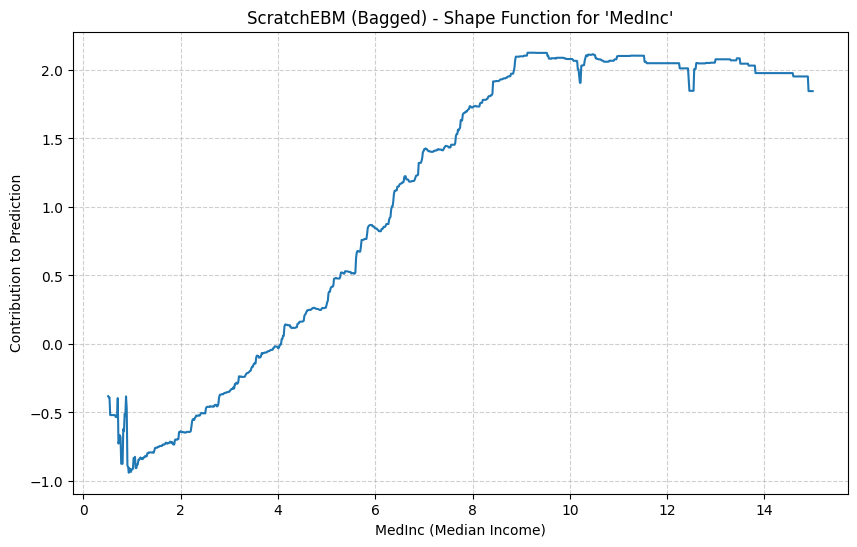


--- Feature: HouseAge ---


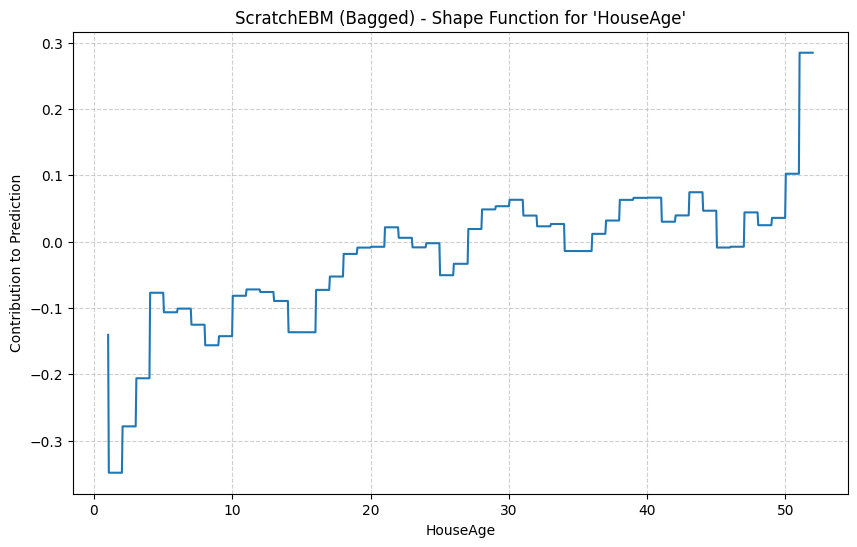

In [12]:
# --- Section 4: Visual Comparison of Shape Functions (Sequential Plots) ---

print("\n--- Generating Shape Function Comparison Plots ---")

# We already have the trained models:
# scratch_bagged_model (your implementation)
# iml_ebm (the library's implementation)

# We also need the global explanation object from the library model
iml_global_explanation = iml_ebm.explain_global()

# Get the feature names for plotting
feature_names = housing.feature_names

# --- Comparison for Feature 1: 'MedInc' ---
medinc_index = feature_names.index('MedInc')

print("\n--- Feature: MedInc ---")

# 1. Plot from your ScratchEBM (Bagged)
plt.figure(figsize=(10, 6))
shape_function = scratch_bagged_model.final_model.feature_shapes_[medinc_index]
bin_edges = scratch_bagged_model.final_model.bin_edges_[medinc_index]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, shape_function)
plt.title("ScratchEBM (Bagged) - Shape Function for 'MedInc'")
plt.xlabel("MedInc (Median Income)")
plt.ylabel("Contribution to Prediction")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Comparison for Feature 2: 'HouseAge' ---
houseage_index = feature_names.index('HouseAge')

print("\n--- Feature: HouseAge ---")

# 1. Plot from your ScratchEBM (Bagged)
plt.figure(figsize=(10, 6))
shape_function = scratch_bagged_model.final_model.feature_shapes_[houseage_index]
bin_edges = scratch_bagged_model.final_model.bin_edges_[houseage_index]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, shape_function)
plt.title("ScratchEBM (Bagged) - Shape Function for 'HouseAge'")
plt.xlabel("HouseAge")
plt.ylabel("Contribution to Prediction")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [13]:
# Plot from interpretML
show(iml_global_explanation)